#Scripts de PyPlot para hacer figuras chingonas para poster

Primero, vamos a intentarlo con un experimento que tenga una actividad notoria. Aquí cargamos un archivo que contiene los datos de un experimento con actividad epiléptica. La región CA aparece muy activa varias veces en las mediciones del potencial de campo local, LFP de ahora en adelante.

In [1]:
using PyPlot

INFO: Loading help data...


In [2]:
muacamuaca=open("../Actividad4AP/DatosActividadEpilepticaSelectos.bin", "r")
formaarray=(64,64,5001)
DatosExperimentales=read(muacamuaca, Float64, formaarray);
close(muacamuaca)

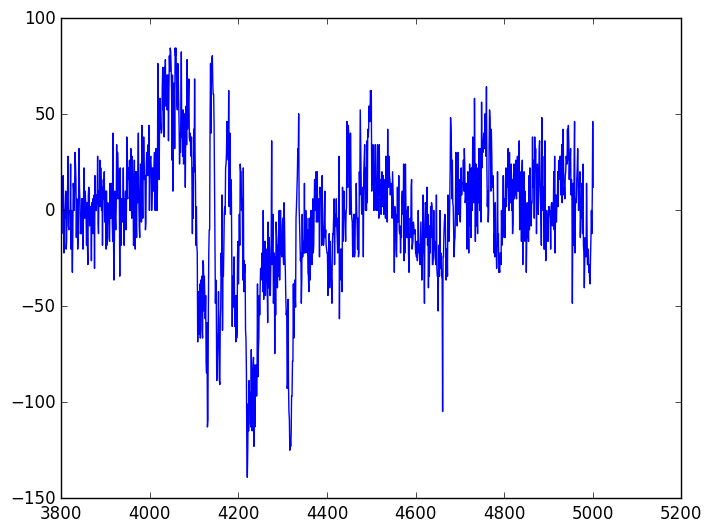

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f96784f79b0>

In [3]:
#No todos los datos son interesantes
ion()
intervalo=3800:5001
plot(intervalo, vec(DatosExperimentales[52,40,intervalo]))

In [4]:
DatosExperimentales=DatosExperimentales[:,:,intervalo];
(alto,ancho,tmax)=size(DatosExperimentales)
map!(x-> abs(x)>1750? 0: x, DatosExperimentales);


In [15]:
puntox=[44,48,52,54,58, 63]
puntoy=[38,42,45,47,50, 54]
puntoy=puntoy+3
puntol=["F","E", "D", "C", "B","A"];

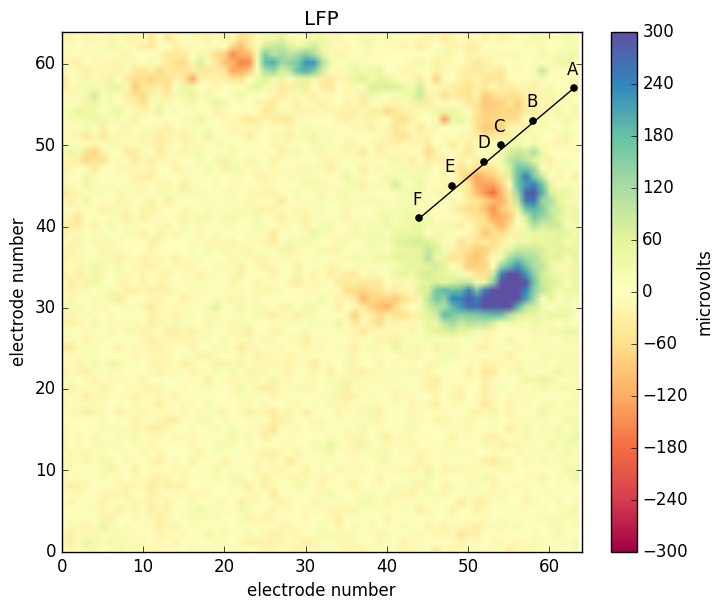

In [20]:
figure(figsize=(7.5,6.5))
title("LFP")
limites=300
PyPlot.xlim(0,64)
PyPlot.ylim(0,64)

for punto in 1:6
    annotate(puntol[punto], (puntox[punto], puntoy[punto]), xytext=(-5,10), textcoords="offset points")
end
imagen=imshow(transpose(DatosExperimentales[:,:,350]), cmap="Spectral", origin="lower", vmin=-limites, vmax=limites)

scatter(puntox,puntoy, marker="o", s=20, c="black")

plot([44, 63], [41, 57], "k-")

cbx=colorbar(imagen, fraction=0.045) 
cbx[:set_label]("microvolts")
xlabel("electrode number")
ylabel("electrode number")

savefig("LFP_Recorded_350_with_selected_electrodes_01.png", dpi=90)

Por consistencia, vamos a transponer todos los datos para que las imagenes coincidan con las de Franco

In [21]:
for t=1:tmax
    DatosExperimentales[:,:,t]=transpose(DatosExperimentales[:,:,t])
end

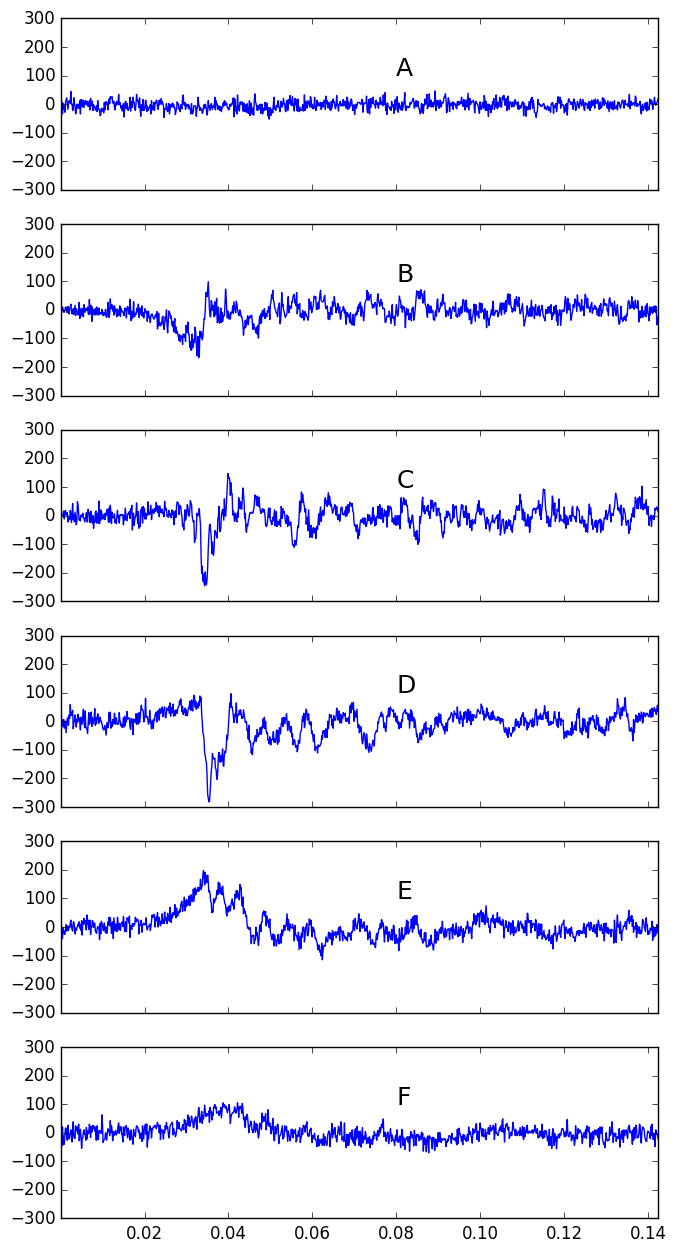

In [23]:
tiempo=1:1000
t=700

farofa, lista=subplots(6, sharex=true, sharey=true, figsize=(7.7,6*2.5))

for j=1:6
    PyPlot.xlim(1/7022,1000/7022)
    PyPlot.ylim(-300,300)
    lista[j][:plot](tiempo/7022,vec(DatosExperimentales[puntoy[7-j],puntox[7-j],tiempo]))
    lista[j][:annotate](puntol[7-j],xy=(0.08,100), annotation_clip=false, fontsize=18)
end

savefig("LFP_A-F_Points_01.svg",dpi=90)

In [37]:
function ListaPixelesdeLinea(x::Array, y::Array)
    #obtener una lista de pixeles/electrodos a lo largo de una linea con dos endpoints enteros.
    #Se ponen las dos coordenadas x en un arreglo y las dos y en otro-
    xuno, xdos=x[1], x[2]
    yuno, ydos=y[1],y[2]
    longitud=abs(xuno-xdos)
    m=(ydos-yuno)/(xdos-xuno)
    xresult=[xuno:xdos] #asumimos que el xdos es el grande!
    yresult=zeros(Int, longitud+1)
    for j in 1:longitud+1
        yresult[j]=int(yuno+(j-1)*m)
    end
    return (xresult,yresult)
end

ListaPixelesdeLinea (generic function with 1 method)

In [45]:
xs=[44,63]
ys=[38,54]+3
(xxs,yys)=ListaPixelesdeLinea(xs,ys);


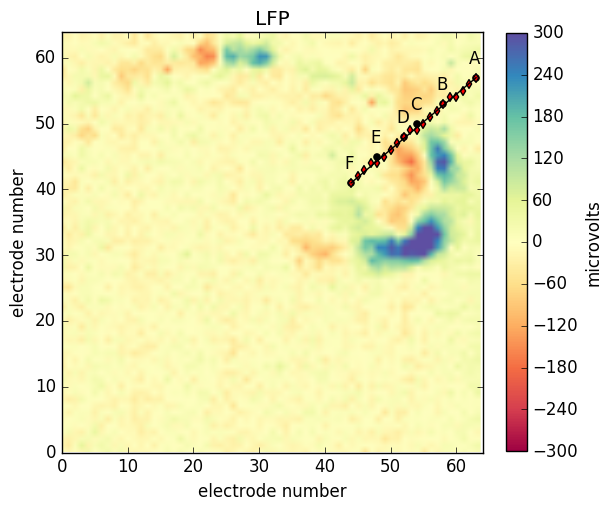

PyObject <matplotlib.text.Text object at 0x7f96716a6ba8>

In [49]:
figure(figsize=(6,6.0))
title("LFP")
limites=300
PyPlot.xlim(0,64)
PyPlot.ylim(0,64)

for punto in 1:6
    annotate(puntol[punto], (puntox[punto], puntoy[punto]), xytext=(-5,10), textcoords="offset points")
end
imagen=imshow((DatosExperimentales[:,:,350]), cmap="Spectral", origin="lower", vmin=-limites, vmax=limites)

scatter(puntox,puntoy, marker="o", s=20, c="black")
scatter(xxs,yys, marker="d", s=20, c="r")

plot([44, 63], [41, 57], "k-")

cbx=colorbar(imagen, fraction=0.045) 
cbx[:set_label]("microvolts")
xlabel("electrode number")
ylabel("electrode number")

#savefig("LFP_Recorded_350_with_selected_electrodes_01.png", dpi=90)

In [54]:
arregloparacascada=zeros(length(xxs),tmax);
for j in 1:length(xxs)
    arregloparacascada[j,:]=DatosExperimentales[xxs[j],yys[j],:]
end
writedlm("LFP_spaciotemporal_01.dat", transpose(arregloparacascada))

In [55]:
function UnNormGauss(x,sigma)
    return exp(-x*x/(2*sigma))
end

function GaussSuavizar(Datos,Sigma)  
    #sigma esta medido en pixeles, es la desviacion estandar de nuestro kernel.
    #El medioancho de nuestra ventana seran 3*sigma
    medioancho=ceil(Sigma*3)
    colchon=ones(medioancho)
    result=zeros(Datos)
    datoscolchon=vcat(colchon*Datos[1], Datos, colchon*Datos[end])
    kernel=map(x->UnNormGauss(x,Sigma), [-medioancho:medioancho])
    kernel=kernel/(sum(kernel))
    #La convolucion asi normalizada preserva el valor RELATIVO entre los puntos de la funcion.
    #pero queremos ponerlo mas parecido a los voltajes que medimos, para preservar el rango de valores
    #experimentales y su criterio de potenciales de accion / ruido
    for t=medioancho+1:length(Datos)-medioancho
        result[t-medioancho]=sum(datoscolchon[t-medioancho:t+medioancho].*kernel)
    end
    a=maximum(abs(Datos))
    b=maximum(abs(result))
    #nromalizacion 
    #result=result*a/b
    return result
end
    
GaussianKernel=readdlm("GaussianMatrix.dat")

function GaussianSmooth(Datos)
    tamanodatos=size(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    for j=1:3
        temp=vcat(temp[1,:], temp, temp[end,:])
    end
    for j=1:3
        temp=hcat(temp[:,1], temp, temp[:,1])
    end
    
    for j=4:tamanodatos[1]+3, k=4:tamanodatos[2]+3
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-3:j+3,k-3:k+3]
        result[j-3,k-3]=sum(GaussianKernel.*aux)
    end
    #Esta convolución no respeta norma L2
    #result=result*maximum(abs(Datos))/maximum(abs(result))
    return result
end

GaussianSmooth (generic function with 1 method)

In [58]:
LFPSuave=zeros(DatosExperimentales);
for j=1:64, k=1:64
    LFPSuave[j,k,:]=GaussSuavizar(reshape(DatosExperimentales[j,k,:],tmax),7)
end

In [61]:
LFPPlanchado=zeros(LFPSuave)
for t=1:tmax
    LFPPlanchado[:,:,t]=GaussianSmooth(LFPSuave[:,:,t])
end

In [62]:
arregloparacascada=zeros(length(xxs),tmax);
for j in 1:length(xxs)
    arregloparacascada[j,:]=LFPPlanchado[xxs[j],yys[j],:]
end
writedlm("LFPPlanchado_spaciotemporal_01.dat", transpose(arregloparacascada))

In [6]:
function DropPeques(data)
    #solo funciona con data de dos indices.
    renglones,colus=size(data)
    prom=mean(abs(data[3]))
    result=zeros(1,colus)
    for k=1:renglones
        if abs(data[k,3])>prom
            result=vcat(result,data[k,:])
        end
    end
    return result
end

DropPeques (generic function with 1 method)

In [7]:
t=2875
EjemploCentrosCSDPos=readdlm("CentrosMasa/CMPosLapla-$t.dat")
EjemploCentrosCSDPos=DropPeques(EjemploCentrosCSDPos)
xxpos=EjemploCentrosCSDPos[:,1]
yypos=EjemploCentrosCSDPos[:,2]
valorpos=EjemploCentrosCSDPos[:,3]
EjemploCentrosCSDNeg=readdlm("CentrosMasa/CMNegLapla-$t.dat")
EjemploCentrosCSDNeg=DropPeques(EjemploCentrosCSDNeg)
xxneg=EjemploCentrosCSDNeg[:,1]
yyneg=EjemploCentrosCSDNeg[:,2]
valorneg=EjemploCentrosCSDNeg[:,3];
CSDEjemplo=readdlm("CentrosMasa/CSD-$t.dat");

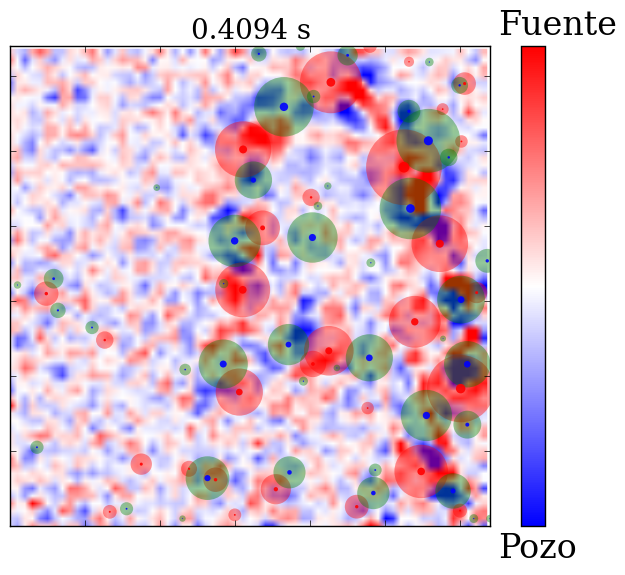

false

In [8]:
PyPlot.ion()
#################
font1 = ["family"=>"DejaVu Serif",
    "color"=>"black",
    "weight"=>"normal",
    "size"=>20]
seg=round(t/7022, 4)
titulo="$seg s"
figure()
PyPlot.xlim(0,64)
PyPlot.ylim(0,64)
tick_params(labelbottom="off", labelleft="off")
otraimagen=imshow(CSDEjemplo, cmap="bwr", origin="lower", vmin=-50, vmax=50)
#cb=colorbar(otraimagen)
#cb=colorbar(otraimagen, ticks=[-150, +150],fraction=0.046, pad=0.04, use_gridspace='True')
cb=colorbar(otraimagen, ticks=[-150, +150], use_gridspec="True")
#farofa=cb[:set_ticklabels]([{"Sink"}, {"Source"}])
#xlabel("furufu", fontdict=font1)

scatter(xxpos,yypos, s=valorpos, alpha=0.4, c="r", edgecolors="none")
scatter(xxneg, yyneg, s=abs(valorneg), alpha=0.4, c="g", edgecolors="none")
scatter(xxpos,yypos, s=0.02*valorpos, alpha=0.9, c="r", edgecolors="none")
scatter(xxneg, yyneg,s=0.02*abs(valorneg), alpha=0.9, c="b", edgecolors="none")


annotate("Pozo",
    xy=[1.05;-0.11],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
font_properties="DejaVu Serif",
    fontsize=24.0,
    ha="left",
    va="bottom")

annotate("Fuente",
    xy=[1.05;0.98],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
font_properties=("DejaVu Serif"),
    fontsize=24,
    ha="left",
   va="bottom")


title(titulo, fontdict=font1)
 #tight_layout()
#savefig("CSDCM_SeminarioAgosto-cb-$t.png", dpi=90)
PyPlot.close_queued_figs()

In [9]:
dedonde, adonde = 1000, 3500
PyPlot.ioff()

In [10]:
@time for t=3176:adonde
    #read the data
    EjemploCentrosCSDPos=readdlm("CentrosMasa/CMPosLapla-$t.dat")
    EjemploCentrosCSDPos=DropPeques(EjemploCentrosCSDPos)
    
    xxpos=EjemploCentrosCSDPos[:,1]
    yypos=EjemploCentrosCSDPos[:,2]
    valorpos=EjemploCentrosCSDPos[:,3]
    EjemploCentrosCSDNeg=readdlm("CentrosMasa/CMNegLapla-$t.dat")
    EjemploCentrosCSDNeg=DropPeques(EjemploCentrosCSDNeg)

    xxneg=EjemploCentrosCSDNeg[:,1]
    yyneg=EjemploCentrosCSDNeg[:,2]
    valorneg=EjemploCentrosCSDNeg[:,3];
    CSDEjemplo=readdlm("CentrosMasa/CSD-$t.dat");
    #plot the data
    lafigura=figure()
    seg=round(t/7022, 4)
    titulo="$seg s"
    PyPlot.xlim(0,63.5)
    PyPlot.ylim(0,63.5)
    
    otraimagen=imshow(CSDEjemplo, cmap="bwr", origin="upper", vmin=-70, vmax=70)
    #cb=colorbar(otraimagen)
    cb=colorbar(otraimagen, ticks=[-150, +150],fraction=0.046, pad=0.04 )
    cb[:set_ticklabels]([{""}, {""}])
    
    cb[:set_ticklabels](["Pozo", "Fuente"])
    cb[:ax][:tick_params](labelsize=12)

    
    scatter(xxpos,yypos, s=valorpos, alpha=0.4, c="r")
    scatter(xxneg, yyneg, s=abs(valorneg), alpha=0.4, c="g")
    scatter(xxpos,yypos, s=0.01*valorpos, alpha=0.95, c="r", edgecolors="none")
    scatter(xxneg, yyneg,s=0.01*abs(valorneg), alpha=0.95, c="b", edgecolors="none")
    #plot(xxpos,yypos, "k+")
    #plot(xxneg, yyneg,"k+")

    title(titulo, fontdict=font1)
    savefig("CentrosMasa/CSD_CM_Agosto-$t.png", dpi=72)
    lafigura[:clf]()
    PyPlot.close()
    lafigura=None
end

elapsed time: 136.182283485 seconds (247855776 bytes allocated, 0.18% gc time)


In [11]:
PyPlot.close()
PyPlot.close_queued_figs()

In [12]:
#guacala de jet. pero les gusta a los Journ. de Neurosc.
PyPlot.ion()
#for t=dedonde+10:adonde
t=732
lala=figure()
tick_params(labelbottom="off", labelleft="off")
b=round(t/7022, 4)
titulo=" $b s"
DatosSuaves=readdlm("GarbageCollector/LFPSuave-$t.dat")
imagen=imshow((DatosSuaves), origin="upper", vmin=-200, vmax=200, interpolation="none")
#cb=colorbar(imagen, ticks=[-200, 0, +200],fraction=0.046, pad=0.04, use_gridspec="True" )
#cb[:set_label]("variación en el potencial [µV]  ", fontsize=20)
cb[:ax][:tick_params](labelsize=20)
title(titulo, fontdict=font1)
tight_layout()
savefig("LFP-$t.png", dpi=90)
PyPlot.close_queued_figs()
gc()
#end

LoadError: opening file GarbageCollector/LFPSuave-732.dat: No existe el fichero o el directorio
while loading In[12], in expression starting on line 9

In [13]:
x=collect(1:64)
y=collect(1:64)
Amplitud=sqrt(EFx.*EFx+EFy.*EFy)
(chico,grande)=extrema(Amplitud)
AmplitudNormalizada=Amplitud/grande
PyPlot.ion()
figure()
xlim(1,64)
ylim(1,64)
#clim(0,120)
flechitas=streamplot(x,y,EFx,EFy, color=AmplitudNormalizada,cmap="Set1", 
density=2, linewidth=2*AmplitudNormalizada);

LoadError: EFx not defined
while loading In[13], in expression starting on line 3